# Algoritmo evolutivo ($\mu+\lambda$)

### Descripción

<font size="4"> Algoritmo evolutivo ($\mu+\lambda$) para optimización continua (minimización).

### Componentes
    
- <font size="3"> Representación real
    
- <font size="3"> Selección por torneo binario
    
- <font size="3"> Muestreo estocástico con reemplazamiento
    
- <font size="3"> Sustitución $(\mu+\lambda)$
    
- <font size="3"> Elitista

- <font size="3"> Cruce uniforme, aritmético y SBX

- <font size="3"> Mutación uniforme, 'small' y polinomial
    
### Comentarios
    
- <font size="3"> Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.

---

### Requerimientos

In [1]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small

In [2]:
G = 1000
N = 100
random_state = 1

p_c = 0.6
uniform_crossover_probability = 1.0 
arithmetic_crossover_probability = 0.0
SBX_crossover_probability = 0.0

p_m = 0.01
uniform_mutation_probability = 1.0
small_mutation_probability = 0.0
polynomial_mutation_probability = 0.0
epsilon = 1e-6

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon
prob = prob_cross,prob_mutation

### Definición del problema de optimización
- $L$: Límite inferior de espacio de búsqueda
- $U$: Límite superior de espacio de búsqueda
- $f$: Función objetivo

In [3]:
def Rastrigin():
    n = 20 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n, 5.12)
    f = lso.rastrigin
    return L,U,f

def Sphere():
    n = 10 # Número de variables de decisión  
    L = np.full(n, -5.12)
    U = np.full(n,  5.12)    
    f = lso.sphere
    return L,U,f

def Rosenbrock():
    n = 5 # Número de variables de decisión  
    L = np.full(n, -2.048)
    U = np.full(n, 2.048)
    f = lso.rosenbrock
    return L,U,f

L,U,f = Rastrigin()
# L,U,f = Sphere()
# L,U,f = Rosenbrock()

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P,L,U):
    n = L.size
    for I in P:
        I.x[:] = np.random.uniform(L, U, n)

### Función de evaluación

In [6]:
def evaluate(I,f):           
    I.f = f(I.x)

### Copia de individuo

In [7]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   

### Selección por torneo binario

In [8]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce con probabilidad $p\_c$ y:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso

In [9]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    x1[:], x2[:] = np.clip(x1,L,U), np.clip(x2,L,U)
    
def crossover(x1,x2,prob_cross,L,U): 
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    if np.random.random()<=p_c:
        r = np.random.random()
        if r<=uniform_crossover_probability:
            uniform_crossover(x1,x2)
        elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
            arithmetic_crossover(x1,x2)
        else:
            SBX_crossover(x1,x2,L,U)

### Mutación
- Mutación con probabilidad $p\_m$ y:
    - mutación uniforme numerica (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso

In [10]:
def uniform_mutation(x,p_m,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = np.random.uniform(L[l],U[l])
    
def small_mutation(x,p_m,epsilon,L,U):
    for l in range(x.size):
        if np.random.random()<=p_m:
            if np.random.random()<=0.5:
                x[l] += np.random.uniform(0,epsilon)
            else:
                x[l] -= np.random.uniform(0,epsilon)
    x[:] = np.clip(x,L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for l in range(x.size):
        if np.random.random()<=p_m:
            u = np.random.random()
            if u<=0.5:
                 x[l] += ((2*u)**(1/(1+eta_m))-1)*(x[l]-L[l])
            else:
                 x[l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[l])
    x[:] = np.clip(x,L,U)
                
def mutation(x,prob_mutation,L,U):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    r = np.random.random()
    if r<=uniform_mutation_probability:
        uniform_mutation(x,p_m,L,U)
    elif r<=uniform_mutation_probability+small_mutation_probability:
        small_mutation(x,p_m,epsilon,L,U)
    else:
        polynomial_mutation(x,p_m,L,U)

### Progreso del algoritmo

In [11]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs,progression_bar):
    best_fitness = min(P).f
    progression_bar.set_description("Generation: %s Fitness: %s " % (str(gen), str(best_fitness)))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

In [12]:
def EA(G,N,prob,f,L,U,random_state):
    
    np.random.seed(random_state)
    
    prob_cross,prob_mutation = prob
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon = prob_mutation
    
    # Aserciones
    
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    AssertProbability(uniform_crossover_probability)
    AssertProbability(arithmetic_crossover_probability)
    AssertProbability(SBX_crossover_probability)    
    assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."
    
    AssertProbability(p_m)
    AssertProbability(uniform_mutation_probability)
    AssertProbability(small_mutation_probability)
    AssertProbability(polynomial_mutation_probability)
    assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."

    n = L.size # Número de variables de decisión  
    
    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P,L,U)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,f)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],binary_tournament_selection(P))
            copia(Q[i+1],binary_tournament_selection(P))
            crossover(Q[i].x,Q[i+1].x,prob_cross,L,U)
            mutation(Q[i].x,prob_mutation,L,U)
            mutation(Q[i+1].x,prob_mutation,L,U)
            evaluate(Q[i],f)
            evaluate(Q[i+1],f)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs,progression_bar)
    best_individuo = min(P)
    return best_outputs, best_individuo.f, best_individuo.x

### Ejecución del algoritmo evolutivo

In [13]:
%%time
best_outputs, best_fitness, best_solution = EA(G,N,prob,f,L,U,random_state)
print("x: ",best_solution)
print("f: ",best_fitness)

Generation: 1000 Fitness: 0.3601598105043706 : : 1001it [00:18, 52.95it/s]

x:  [ 0.00939177 -0.00298931 -0.00404043  0.00063761  0.00491089  0.0098942
  0.0001905  -0.01600249  0.00061771  0.00022749  0.00209276 -0.01816224
 -0.00935213 -0.00319171  0.02455822 -0.01221757 -0.00338214  0.0051323
  0.00618113 -0.00804007]
f:  0.3601598105043706
CPU times: total: 18.1 s
Wall time: 18.9 s


### Visualización de la evolución del algoritmo

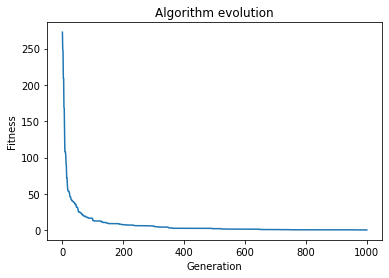

In [14]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()
    
VisualizaEvolucion(best_outputs)